<a href="https://colab.research.google.com/github/mohamed-habib-jaberi/Deep-Learning/blob/main/Transfer_Learning_with_TensorFlow_Part_3__Scaling_up_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3: Scaling up

In [15]:
# Check to see if we're using a GPU
!nvidia-smi

Tue Oct 21 23:23:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   65C    P0             30W /   70W |    2164MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**Creating helper functions**

In previous notebooks, we've created a series of helper functions to do different tasks, let's download them.

In [2]:
!wget https://raw.githubusercontent.com/mohamed-habib-jaberi/Deep-Learning/refs/heads/main/Computer%20Vision%20and%20CNN%20in%20TensorFlow/helper_functions.py

--2025-10-21 23:10:46--  https://raw.githubusercontent.com/mohamed-habib-jaberi/Deep-Learning/refs/heads/main/Computer%20Vision%20and%20CNN%20in%20TensorFlow/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10245 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.00K  --.-KB/s    in 0s      

2025-10-21 23:10:46 (51.6 MB/s) - ‘helper_functions.py’ saved [10245/10245]



In [3]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir



**101 Food Classes: working with less data**

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2025-10-21 23:10:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.207, 172.217.218.207, 142.251.31.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  42.2MB/s    in 39s     

2025-10-21 23:11:32 (39.7 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/poutine'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/croque_madame'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/macarons'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hot_dog'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/deviled_eggs'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/seaweed_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/gnocchi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/mussels'.
There are 0 directories and 250 images in '101_food_c

In [6]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


**Train a our model with transfer learning on 10% of 101 food classes**


Here are the steps we're going to take:

* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [7]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [8]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  layers.RandomZoom(0.2),
  # preprocessing.Rescaling(1/255.) # rescale inputs of images to between 0 & 1, required for models like ResNet50
], name="data_augmentation")

In [9]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode so weights which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
# Get a summary of model we've created
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool_layer           │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # validate on only 15% of test data during training
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 54s 168ms/step - accuracy: 0.1553 - loss: 3.9849 - val_accuracy: 0.4568 - val_loss: 2.5045
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 75s 156ms/step - accuracy: 0.4846 - loss: 2.3232 - val_accuracy: 0.5193 - val_loss: 2.0272
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.5645 - loss: 1.8939 - val_accuracy: 0.5350 - val_loss: 1.8698
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 36s 153ms/step - accuracy: 0.5971 - loss: 1.6786 - val_accuracy: 0.5516 - val_loss: 1.7749
Epoch 5/5
137/237 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.6234 - loss: 1.5229

In [ ]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

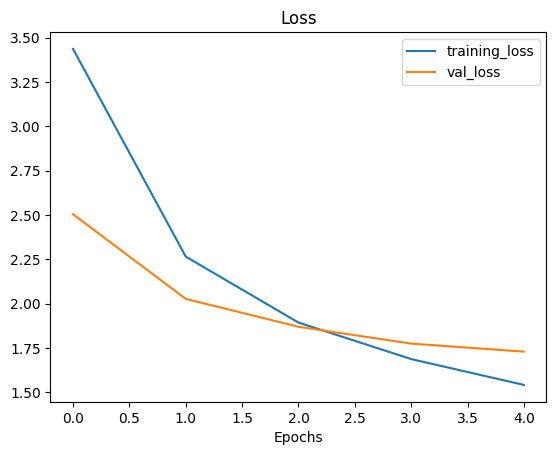

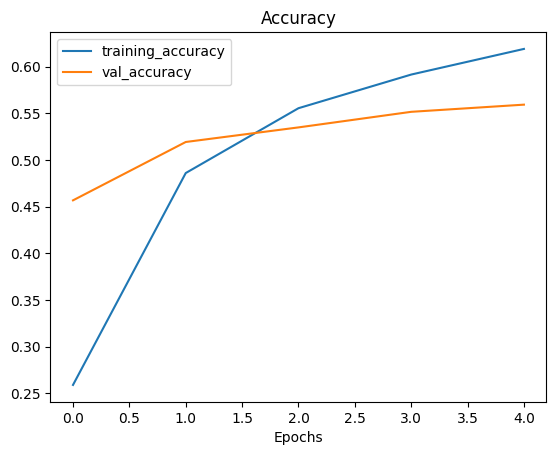

In [16]:
plot_loss_curves(history_all_classes_10_percent)